In [1]:
import astropy
import galsim
import matplotlib.pyplot as plt
import numpy as np
import scarlet
import sep

import btk

# SCARLET implementation

This notebook provides a measure function using [SCARLET](https://www.sciencedirect.com/science/article/abs/pii/S2213133718300301), a deblending algorithm based on matrix factorization ; it requires that you install the scarlet python package from the [source](https://github.com/pmelchior/scarlet), the pip installation being outdated. If you have not done so already, we encourage you to follow the intro tutorial, which will help you understand what is done in this notebook.

In [2]:
catalog_name = "../data/sample_input_catalog.fits"
stamp_size = 24
survey = btk.survey.Rubin


In [3]:
catalog = btk.catalog.CatsimCatalog.from_file(catalog_name)
draw_blend_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    btk.sampling_functions.DefaultSampling(max_number=10,maxshift=6),
    [survey],
    stamp_size=stamp_size,
    batch_size=100
)

In [6]:
def scarlet_measure(batch,idx,channels_last=False,surveys=None,**kwargs):
    if isinstance(batch["blend_images"], dict):
        raise NotImplementedError("This function does not support the multi-resolution feature.")
        
    sigma_noise = kwargs.get("sigma_noise", 1.5)
    mean_sky_level = [btk.survey.get_mean_sky_level(surveys[0],filt) for filt in surveys[0].filters]

    image = batch["blend_images"][idx]
    stamp_size = image.shape[-2]  # true for both 'NCHW' or 'NHWC' formats.
    channel_indx = 0 if not channels_last else -1
    coadd = np.mean(image, axis=channel_indx)  # Smallest dimension is the channels
    bkg = sep.Background(coadd)
    # Here the 1.5 value corresponds to a 1.5 sigma threshold for detection against noise.
    catalog, segmentation = sep.extract(
        coadd, sigma_noise, err=bkg.globalrms, segmentation_map=True
    )
    
    image = np.moveaxis(image,-1,0) if channels_last else image
    
    psf = np.array([p.drawImage(galsim.Image(image.shape[1],image.shape[2]),scale=survey.pixel_scale).array for p in batch["psf"]])
    #Initializing scarlet
    bands=[0,1,2,3,4,5]
    model_psf = scarlet.GaussianPSF(sigma=(0.8,) * len(bands))
    model_frame = scarlet.Frame(image.shape, psf=model_psf, channels=bands)
    observation = scarlet.Observation(
        image, psf=scarlet.ImagePSF(psf), weights=1.0 / (image+np.resize(mean_sky_level,image.shape)), channels=bands
    ).match(model_frame)
    sources = []
    for n, detection in enumerate(catalog):
        result = scarlet.ExtendedSource(
            model_frame,
            (detection["y"], detection["x"]),
            observation,
            thresh=1,
            shifting=True,
        )
        sources.append(result)
    blend = scarlet.Blend(sources, observation)
    blend.fit(200, e_rel=1e-5)
    
    im, selected_peaks = [], []
    model=blend.get_model()
    model_ = observation.render(model)
    for k, component in enumerate(blend):
        y, x = component.center
        selected_peaks.append([x, y])
        model = component.get_model(frame=model_frame)
        model_ = observation.render(model)
        model_ = np.transpose(model_, axes=(1, 2, 0)) if channels_last else model_
        im.append(model_)
    selected_peaks = np.array(selected_peaks)
    t = astropy.table.Table()
    t["x_peak"] = selected_peaks[:,0]
    t["y_peak"] = selected_peaks[:,1]
    
    return {"catalog":t,"segmentation":None,"deblended_images":np.array(im)}
    
    

In [7]:
measure_kwargs=[{"sigma_noise": 2.0},
                {"sigma_noise": 3.0}]
meas_generator = btk.measure.MeasureGenerator(
    scarlet_measure, draw_blend_generator, measure_kwargs=measure_kwargs
)
metrics_generator = btk.metrics.MetricsGenerator(
    meas_generator,
    use_metrics=("detection", "reconstruction"),
    target_meas={"ellipticity": btk.metrics.meas_ksb_ellipticity},
)


In [8]:
blend_results,measure_results,metrics_results = next(metrics_generator)

/home/thuiop/Documents/stageAPC/BlendingToolKit/env/lib64/python3.7/site-packages/autograd-1.3-py3.7.egg/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in sqrt
  return f_raw(*args, **kwargs)


Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Unphysical situation: galaxy convolved with PSF is smaller than PSF!

Unphysical situation: galaxy convolved with PSF is smaller than PSF!

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment 

Error: NaN in calculation of adaptive moments

Error: NaN in calculation of adaptive moments

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: NaN in calculation of adaptive moments

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: NaN in calculation of adaptive moments

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Unphys

Error: adaptive moment failed

Error: adaptive moment failed

Unphysical situation: galaxy convolved with PSF is smaller than PSF!

Unphysical situation: galaxy convolved with PSF is smaller than PSF!

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Unphysical situation: galaxy convolved with PSF is smaller than PSF!

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive

Unphysical situation: galaxy convolved with PSF is smaller than PSF!

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Unphysical situation: galaxy convolved with PSF is smaller than PSF!

Error: adaptive moment 

Error: adaptive moment failed

Error: NaN in calculation of adaptive moments

Error: adaptive moment failed

Error: adaptive moment failed

Unphysical situation: galaxy convolved with PSF is smaller than PSF!

Unphysical situation: galaxy convolved with PSF is smaller than PSF!

Error: adaptive moment failed

Error: adaptive moment failed

Unphysical situation: galaxy convolved with PSF is smaller than PSF!

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Error: adaptive moment failed

Unphysical situation: galaxy c

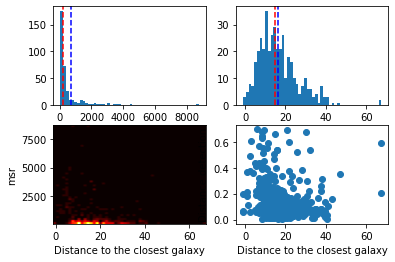

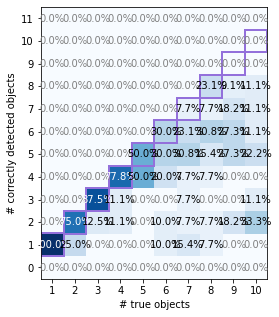

In [11]:
results = metrics_results["scarlet_measure0"]
gal_summary = results["galaxy_summary"][results["galaxy_summary"]["detected"]==True]
msr = gal_summary["msr"]
dist = gal_summary["distance_closest_galaxy"]
dist_detect = gal_summary["distance_detection"]

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
btk.plot_utils.plot_metrics_distribution(msr,"msr",ax1,upper_quantile=0.9)
btk.plot_utils.plot_metrics_distribution(dist,"Distance to the closest galaxy",ax2)
btk.plot_utils.plot_metrics_correlation(dist,msr,"Distance to the closest galaxy","msr",ax3,upper_quantile=0.9,style='heatmap')
btk.plot_utils.plot_metrics_correlation(dist,dist_detect,"Distance to the closest galaxy","Distance detection",ax4,upper_quantile=0.9,style='scatter')
plt.show()

btk.plot_utils.plot_efficiency_matrix(results["detection"]["eff_matrix"])